# Autoencoders and LSTM's in keras

A basic example on buil;ding a time-series autoencoder based on LSTM's in keras. A small application in the end shows how to use it in combination with quantile regression in order to detect outliers. 

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime

print(tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

2.1.0


## Create dummy data

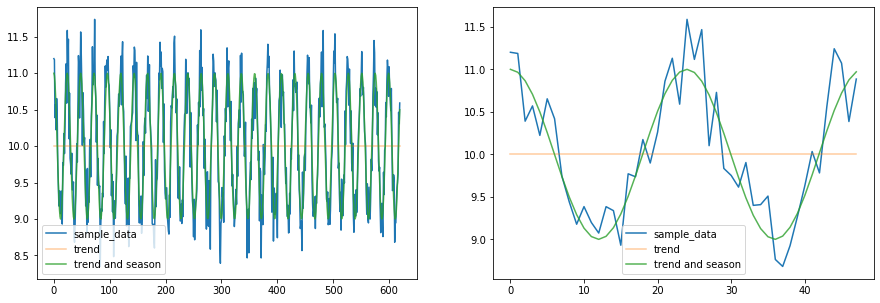

In [2]:
"""
Create dummy data
"""

samples = 620
season_number = 24
slope_trend = 0  # a non-zero trend gives the model quite some trouble. For illustration purposes set to 0.
intercept_trend = 10
noise_sigma = .3

trend = np.linspace(0, samples, samples)
season = np.cos(trend * 2 *np.pi / season_number)
trend = slope_trend * trend + intercept_trend
noise = np.random.normal(0, noise_sigma, samples)

sample_data_ts = trend + season + noise

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(sample_data_ts, label='sample_data')
ax[0].plot(trend, label='trend', alpha=.4)
ax[0].plot(trend + season, label='trend and season', alpha=.8)
ax[0].legend()

ax[1].plot(sample_data_ts[:48], label='sample_data')
ax[1].plot(trend[:48], label='trend', alpha=.4)
ax[1].plot((trend + season)[:48], label='trend and season', alpha=.8)
ax[1].legend()

plt.show()

In [3]:
def split_sequence(sequence, n_steps):
    """
    Splits a time-series object into sub-series which can be used for trainig 
    """
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

(465, 36) (85, 36)


array([11.20069697, 11.18675032, 10.39024876, 10.5696916 , 10.2231712 ,
       10.65319766, 10.41892144,  9.74228832,  9.43979086,  9.17798494,
        9.38504154,  9.19820233,  9.07421109,  9.38434011,  9.33768533,
        8.93104334,  9.77100204,  9.73630367, 10.17397878,  9.89819024,
       10.26100827, 10.86013578, 11.13036134, 10.59040252, 11.58791905,
       11.11703236, 11.46696343, 10.10190387, 10.72868874,  9.83448186,
        9.75179339,  9.61460975,  9.90351273,  9.39982108,  9.40839272,
        9.50891205])

array([10.84328446, 11.30352446, 11.14313455, 11.54079705, 10.96891332,
       10.84439523, 10.59734887, 10.61943955, 10.65532996,  9.6963274 ,
        9.77072906,  9.35007079,  9.10211209,  9.36719051,  8.84780273,
        9.54746872,  9.32911667,  9.04178036,  9.33549087,  9.60409686,
        9.49436023, 10.4829853 , 10.02013836, 10.7583672 , 10.89321645,
       11.22921126, 11.19429505, 11.01886966, 10.56240514, 11.05779323,
       10.33787306, 10.03748788, 10.48378992,  9.76602117,  9.65746106,
       10.04060865])

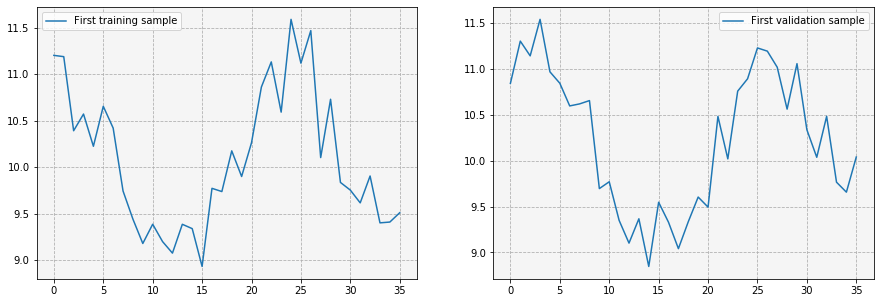

In [4]:
"""
Create training and validation data
"""

split_index = 500
TIMESTEPS_PER_SAMPLE = 36

train_data_ts = sample_data_ts[:split_index]
validation_data_ts = sample_data_ts[split_index:]

train_x = split_sequence(train_data_ts, TIMESTEPS_PER_SAMPLE)
validation_x = split_sequence(validation_data_ts, TIMESTEPS_PER_SAMPLE)

print(train_x.shape, validation_x.shape)

display(train_x[0], validation_x[0])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_x[0], label='First training sample')
ax[1].plot(validation_x[0], label='First validation sample')

for axis in ax:
    axis.legend()
    axis.grid(linestyle="--")
    axis.set_facecolor("whitesmoke")

plt.show()

In [5]:
"""
Expected input shape of LSTM is (samples, timesteps, features).
We nee to reshape the training features to identify that we have only one 
feature per sample and timestep (i.e. dealing with univariate timeseries)
"""

train_x = train_x.reshape(train_x.shape[0], TIMESTEPS_PER_SAMPLE, 1)
validation_x = validation_x.reshape(validation_x.shape[0], TIMESTEPS_PER_SAMPLE, 1)

## Autoencoder LSTM

In [6]:
"""
The autoencoder LSTM basically incorporated omne LSTM to encode the timeseries (reduce to 1D output variable)
and uses a second LSTM to decode it back again to recreate the original time-series from the compressed
information. Since we drastically reduce the dimension in the encoding, we implicitly lose ways to decode 
the noise, so we expect kind of a smoothing effect as wel as a regression to the mean.
"""

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(TIMESTEPS_PER_SAMPLE, 1)))
model.add(RepeatVector(TIMESTEPS_PER_SAMPLE))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 36, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 36, 100)           80400     
_________________________________________________________________
time_distributed (TimeDistri (None, 36, 1)             101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.fit(train_x, train_x, epochs=10, batch_size=5, verbose=1,
          validation_data=(validation_x, validation_x))

Train on 465 samples, validate on 85 samples
Epoch 1/10
465/465 [==============================] - 18s 38ms/sample - loss: 1.7247 - val_loss: 0.6799
Epoch 2/10
465/465 [==============================] - 15s 33ms/sample - loss: 0.6623 - val_loss: 0.6236
Epoch 3/10
465/465 [==============================] - 15s 33ms/sample - loss: 0.6210 - val_loss: 0.6828
Epoch 4/10
465/465 [==============================] - 15s 31ms/sample - loss: 0.5248 - val_loss: 0.3170
Epoch 5/10
465/465 [==============================] - 16s 34ms/sample - loss: 0.4013 - val_loss: 0.2889
Epoch 6/10
465/465 [==============================] - 15s 32ms/sample - loss: 0.2881 - val_loss: 0.2159
Epoch 7/10
465/465 [==============================] - 16s 34ms/sample - loss: 0.2705 - val_loss: 0.2236
Epoch 8/10
465/465 [==============================] - 15s 32ms/sample - loss: 0.2628 - val_loss: 0.2690
Epoch 9/10
465/465 [==============================] - 15s 32ms/sample - loss: 0.2668 - val_loss: 0.2367
Epoch 10/10
465/465

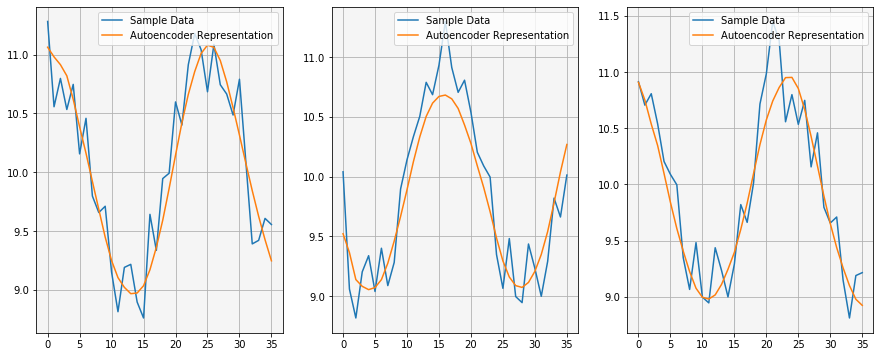

In [8]:
"""Plotting some random validation samples and the autoencoder representation"""

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
for i, s in enumerate(np.random.randint(0, validation_x.shape[0], 3)):
    ax[i].plot(validation_x[s:s+1].reshape(TIMESTEPS_PER_SAMPLE), label="Sample Data")
    ax[i].plot(model.predict(validation_x[s:s+1]).reshape(TIMESTEPS_PER_SAMPLE), label="Autoencoder Representation")
    ax[i].legend()
    ax[i].grid()
    ax[i].set_facecolor("whitesmoke")

## Outlier detection with Autoencoder LSTM and quantile regression

Combining the autoencoder approach with quantile regression, we can get a method for outlier detection. I.e. by using the quantile loss function we get not an de-/encoding of the actual timeseries, but a representation for it's quantiles. Then we can as usual base an outlier detection on a quantile based threshold.

In [9]:
"""
Custom loss function to do quantile regression on other quantiles than the median
source: https://www.evergreeninnovations.co/blog-quantile-loss-function-for-machine-learning/
"""
def quantile_loss(q, y_p, y):
        e = y_p-y
        return tf.keras.backend.mean(tf.keras.backend.maximum(q*e, (q-1)*e))

# define model
model_q = Sequential()
model_q.add(LSTM(100, activation='relu', input_shape=(TIMESTEPS_PER_SAMPLE, 1)))
model_q.add(RepeatVector(TIMESTEPS_PER_SAMPLE))
model_q.add(LSTM(100, activation='relu', return_sequences=True))
model_q.add(TimeDistributed(Dense(1)))
model_q.compile(optimizer='adam', loss=lambda y_p, y: quantile_loss(.95, y_p, y))
model_q.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 36, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 36, 100)           80400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 36, 1)             101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_q.fit(train_x, train_x, epochs=10, batch_size=5, verbose=1, validation_data=(validation_x, validation_x))

Train on 465 samples, validate on 85 samples
Epoch 1/10
465/465 [==============================] - 16s 34ms/sample - loss: 0.0714 - val_loss: 0.0609
Epoch 2/10
465/465 [==============================] - 14s 31ms/sample - loss: 0.0641 - val_loss: 0.0585
Epoch 3/10
465/465 [==============================] - 15s 32ms/sample - loss: 0.0612 - val_loss: 0.0557
Epoch 4/10
465/465 [==============================] - 15s 33ms/sample - loss: 0.0600 - val_loss: 0.0513
Epoch 5/10
465/465 [==============================] - 16s 34ms/sample - loss: 0.0604 - val_loss: 0.0460
Epoch 6/10
465/465 [==============================] - 16s 34ms/sample - loss: 0.0625 - val_loss: 0.0526
Epoch 7/10
465/465 [==============================] - 16s 34ms/sample - loss: 0.0557 - val_loss: 0.0550
Epoch 8/10
465/465 [==============================] - 16s 33ms/sample - loss: 0.0530 - val_loss: 0.0491
Epoch 9/10
465/465 [==============================] - 15s 33ms/sample - loss: 0.0490 - val_loss: 0.0504
Epoch 10/10
465/465

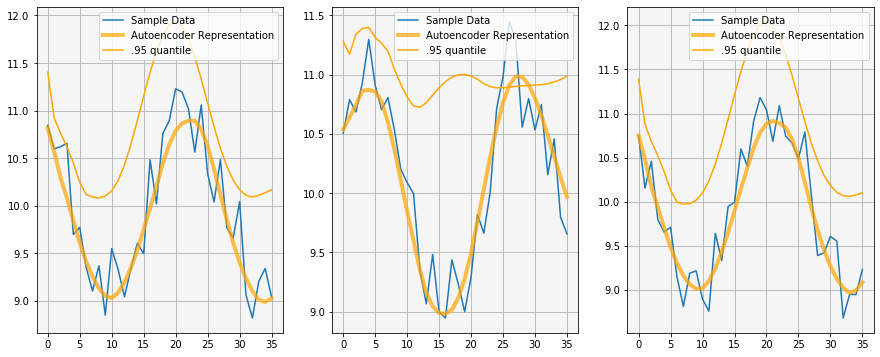

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
for i, s in enumerate(np.random.randint(0, validation_x.shape[0], 3)):
    ax[i].plot(validation_x[s:s+1].reshape(TIMESTEPS_PER_SAMPLE), label="Sample Data")
    ax[i].plot(model.predict(validation_x[s:s+1]).reshape(TIMESTEPS_PER_SAMPLE),
               label="Autoencoder Representation", color='orange', linewidth=4, alpha=.7)
    ax[i].plot(model_q.predict(validation_x[s:s+1]).reshape(TIMESTEPS_PER_SAMPLE),
               label=".95 quantile", color='orange')
    ax[i].legend()
    ax[i].grid()
    ax[i].set_facecolor("whitesmoke")

## Finding something general

In [12]:
trend.slope = 

trend = np.linspace(0, samples, samples)

SyntaxError: invalid syntax (<ipython-input-12-59ddfdfa72cd>, line 1)